In [ ]:
import capytaine as cpt
import numpy as np
import xarray as xr
import os


rho_water = 1000.0
g         = 9.81


meshes = [
    "0_125FlatAkterspeil",
    "0_25FlatAkterspeil",
    "0_5FlatAkterspeil",
    "FlatAkterspeil",
]

omega_range = np.arange(1.0, 12, 0.25)
speeds      = [0]
wave_dirs   = [np.pi]   # following seas



os.makedirs("txt_summaries", exist_ok=True)

for name in meshes:
    print(f"\n=== Processing mesh: {name} ===")
    mesh = cpt.load_mesh(f"{name}.stl")
    center = mesh.center_of_buoyancy
    lid_mesh = mesh.generate_lid()               # create a horizontal cap at z=0


    body = cpt.FloatingBody(
        mesh=mesh.immersed_part(),
        lid_mesh=lid_mesh,
        dofs=cpt.rigid_body_dofs(rotation_center=center),
    )

    body.show()
    body.center_of_mass = center
    body.mass           = body.immersed_part().volume * rho_water
    body.inertia_matrix = body.compute_rigid_body_inertia()
    hydrostatics = body.compute_hydrostatics(rho=1000.0)

    # Build xarray template
    coords = {
        "omega":          omega_range,
        "forward_speed":  speeds,
        "wave_direction": wave_dirs,
        "water_depth":    [np.inf],
        "rho":            [rho_water],
        "radiating_dof":  list(body.dofs.keys()),
    }
    template = xr.Dataset(coords=coords)

    # Solve hydrodynamics + RAO
    dataset = cpt.BEMSolver().fill_dataset(template, body)

    if "forward_speed" not in dataset.dims:
        dataset = dataset.expand_dims({"forward_speed": speeds})
    if "wave_direction" not in dataset.dims:
        dataset = dataset.expand_dims({"wave_direction": wave_dirs})

    rao     = cpt.post_pro.rao(dataset)


    # --- Dump plain-text summary of added mass & damping ---
    txt1 = os.path.join("txt_summaries", f"{name}_added_damping.txt")
    with open(txt1, "w") as f:
        f.write(f"# Mesh: {name}\n\n")
        for U in speeds:
            f.write(f"## Forward speed: {U:.2f} m/s\n")
            for var, label in [
                ("added_mass",        "Added Mass"),
                ("radiation_damping", "Radiation Damping"),
            ]:
                f.write(f"{label}\n")
                da = dataset[var]
                
                if "forward_speed" not in da.dims:
                    da = da.expand_dims({"forward_speed": speeds})
                daU = da.sel(forward_speed=U)
                for ω in omega_range:
                    mat = daU.sel(omega=ω).values
                    for row in mat:
                        f.write(" ".join(f"{v:.6e}" for v in row) + "\n")
                    f.write("\n")
            f.write("---\n")

    # --- Dump plain-text summary of excitation forces ---
    txt2 = os.path.join("txt_summaries", f"{name}_forces.txt")
    with open(txt2, "w") as f:
        f.write(f"# Excitation forces for mesh {name}\n")
        da = dataset["excitation_force"]
        if "forward_speed" not in da.dims:
            da = da.expand_dims({"forward_speed": speeds})
        for U in speeds:
            f.write(f"\n# U={U:.2f} m/s\n")
            daU = da.sel(forward_speed=U)
            for wd in wave_dirs:
                daUW = daU.sel(wave_direction=wd)
                for ω in omega_range:
                    vec = daUW.sel(omega=ω).values
                    f.write(f"{ω:.3f} {wd:.3f} " +
                            " ".join(f"{v:.6e}" for v in vec) + "\n")

    # --- Dump plain-text summary of RAO ---
    txt3 = os.path.join("txt_summaries", f"{name}_rao.txt")
    with open(txt3, "w") as f:
        f.write(f"# RAO for mesh {name}\n")
        da = rao
        if "forward_speed" not in da.dims:
            da = da.expand_dims({"forward_speed": speeds})
        for U in speeds:
            f.write(f"\n# U={U:.2f} m/s\n")
            daU = da.sel(forward_speed=U)
            for wd in wave_dirs:
                daUW = daU.sel(wave_direction=wd)
                for ω in omega_range:
                    vec = daUW.sel(omega=ω).values
                    f.write(f"{ω:.3f} {wd:.3f} " +
                            " ".join(f"{abs(v):.6e}" for v in vec) + "\n")




=== Processing mesh: 0_125FlatAkterspeil ===


[10:20:07] WARNING  Mesh resolution for 91 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 8.750 to 11.750.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


=== Processing mesh: 0_25FlatAkterspeil ===


[10:20:14] WARNING  Mesh resolution for 77 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 9.250 to 11.750.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()


=== Processing mesh: 0_5FlatAkterspeil ===


Output()


=== Processing mesh: FlatAkterspeil ===


Output()

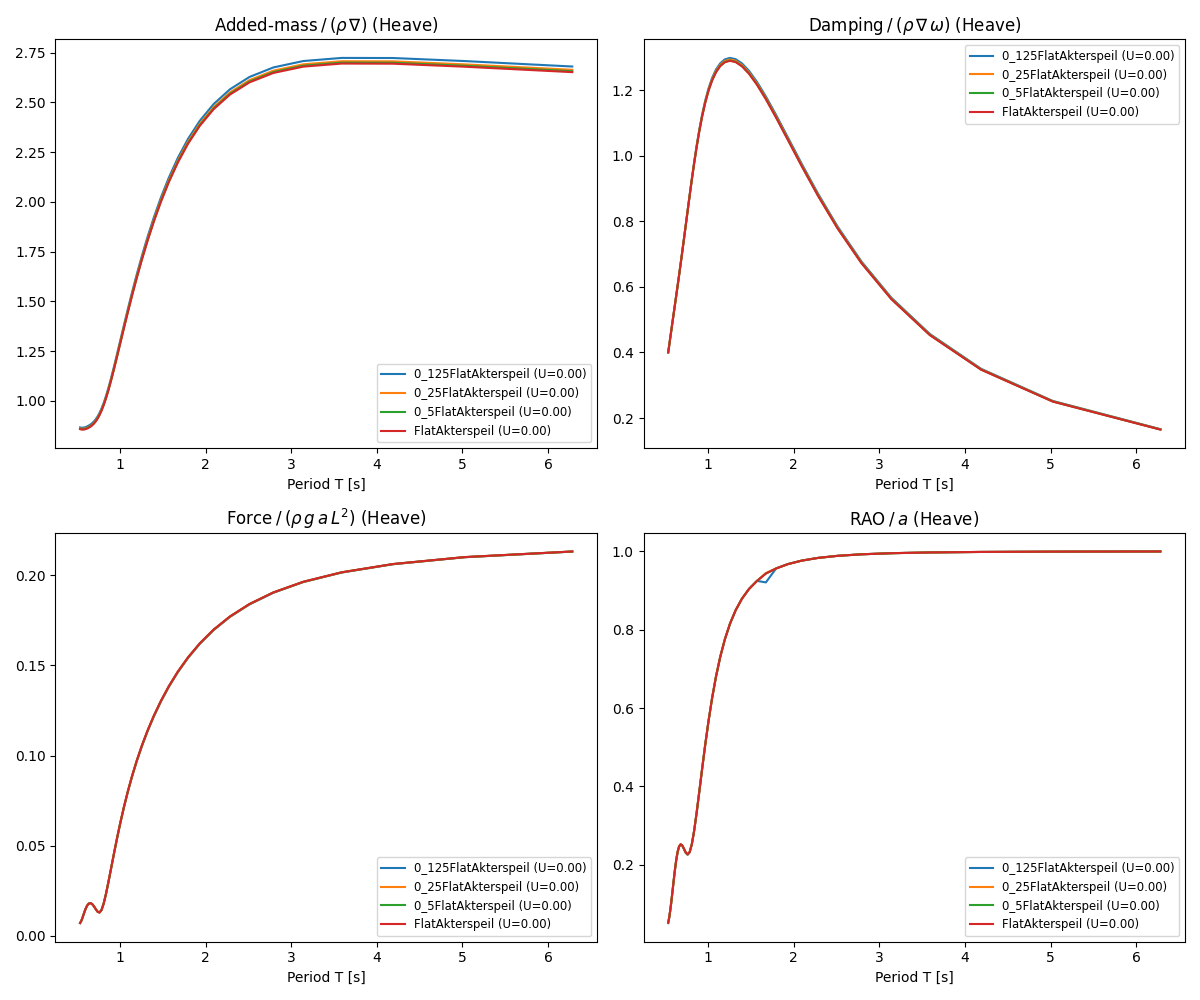

In [ ]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


meshes   = ["0_125FlatAkterspeil","0_25FlatAkterspeil","0_5FlatAkterspeil","FlatAkterspeil"]
omega = np.arange(1.0, 12, 0.25)
period   = 2*np.pi/omega 
speeds   = [0]
wave_dir = float(f"{np.pi:.3f}")  
dof_idx  = 2 #plot dof
n_dofs   = 6




weight    = 14.16            
rho       = 1000.0           
g         = 9.81            
wave_amp  = 1              # unit waveamp
L         = 1.0              # [m], characteristic length

def parse_added_or_damping(mesh, U, var_name):
    fn = os.path.join("txt_summaries", f"{mesh}_added_damping.txt")
    lines = open(fn).read().splitlines()
    tag_speed = f"## Forward speed: {U:.2f} m/s"
    i0 = next(i for i,l in enumerate(lines) if l.strip().startswith(tag_speed))
    label = "Added Mass" if var_name=="added_mass" else "Radiation Damping"
    i1 = next(i for i in range(i0, len(lines)) if lines[i].strip()==label) + 1
    vals, ptr = [], i1
    for _ in omega:
        mat = [list(map(float, lines[ptr+r].split())) for r in range(n_dofs)]
        vals.append(mat[dof_idx][dof_idx])
        ptr += n_dofs + 1
    return np.array(vals)

def parse_vector(mesh, kind):
    fn = os.path.join("txt_summaries", f"{mesh}_{kind}.txt")
    out = {}
    wd_target = f"{wave_dir:.3f}"     
    with open(fn) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("# U="):
                raw = line.split("=",1)[1].split()[0]   
                U_file = float(raw)
                U = next(s for s in speeds if abs(round(s,2)-round(U_file,2))<1e-6)
                out[U] = {}
            elif line.startswith("#"):
                continue
            else:
                parts = line.split()
                w      = float(parts[0])
                wd_str = parts[1]                       
                if wd_str != wd_target:
                    continue
                vals = [abs(complex(s.replace("+-","-"))) for s in parts[2:]]
                out[U][w] = vals[dof_idx]
    return out


AM  = {m:{U:parse_added_or_damping(m,U,"added_mass") for U in speeds} for m in meshes}
RD  = {m:{U:parse_added_or_damping(m,U,"radiation_damping") for U in speeds} for m in meshes}
FX  = {m:parse_vector(m,"forces") for m in meshes}
RAO = {m:parse_vector(m,"rao")    for m in meshes}


fig, axs = plt.subplots(2,2, figsize=(12,10))
axs = axs.flatten()
for mesh in meshes:
    for U in speeds:
        lbl = f"{mesh} (U={U:.2f})"

        # nondimensional added mass and damping
        AM_nd = AM[mesh][U] / weight
        RD_nd = RD[mesh][U] / (weight * omega)

        axs[0].plot(period, AM_nd, label=lbl)
        axs[1].plot(period, RD_nd, label=lbl)

        # nondimensional excitation force
        w3 = sorted(FX[mesh][U])
        y3 = np.array([FX[mesh][U][w] for w in w3])
        Force_nd = y3 / (rho * g * wave_amp * L**2)
        T3 = 2*np.pi/np.array(w3)
        idx3 = np.argsort(T3)
        axs[2].plot(T3[idx3], Force_nd[idx3], label=lbl)

        # nondimensional RAO
        w4 = sorted(RAO[mesh][U])
        y4 = np.array([RAO[mesh][U][w] for w in w4])
        RAO_nd = y4 / wave_amp
        T4 = 2*np.pi/np.array(w4)
        idx4 = np.argsort(T4)
        axs[3].plot(T4[idx4], RAO_nd[idx4], label=lbl)

titles = [
    r"Added‐mass / ($\rho\,\nabla$) (Heave)",
    r"Damping / ($\rho\,\nabla\,\omega$) (Heave)",
    r"Force / ($\rho\,g\,a\,L^{2}$) (Heave)",
    r"RAO / $a$ (Heave)",
]
for ax, t in zip(axs, titles):
    ax.set_title(t)
    ax.set_xlabel("Period T [s]")
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

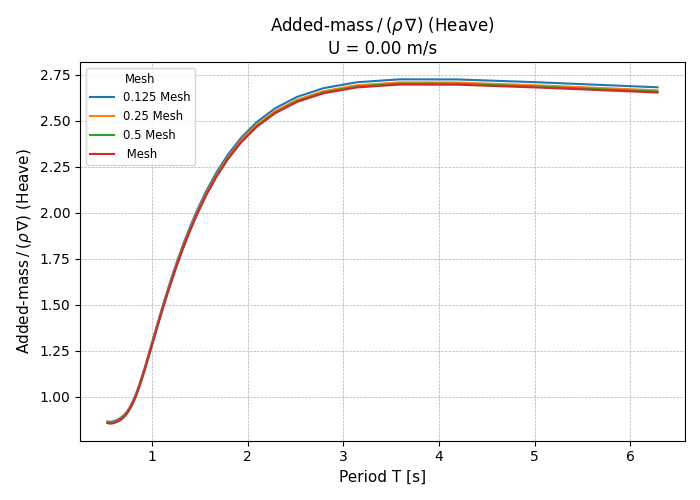

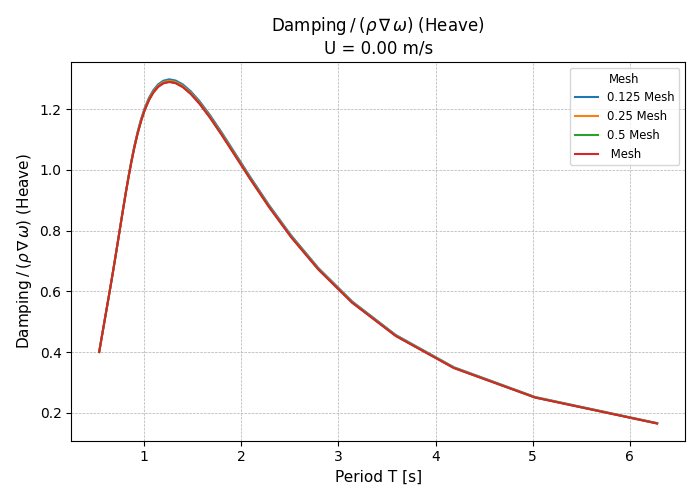

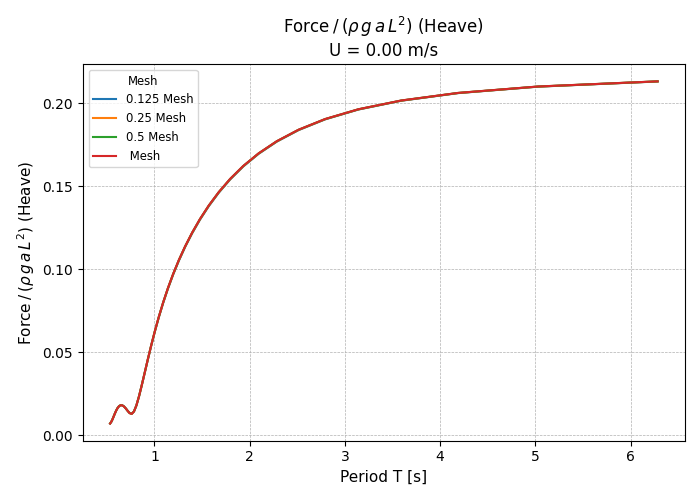

C:\Users\Bruker\AppData\Local\Temp\ipykernel_19068\252762909.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7,5))


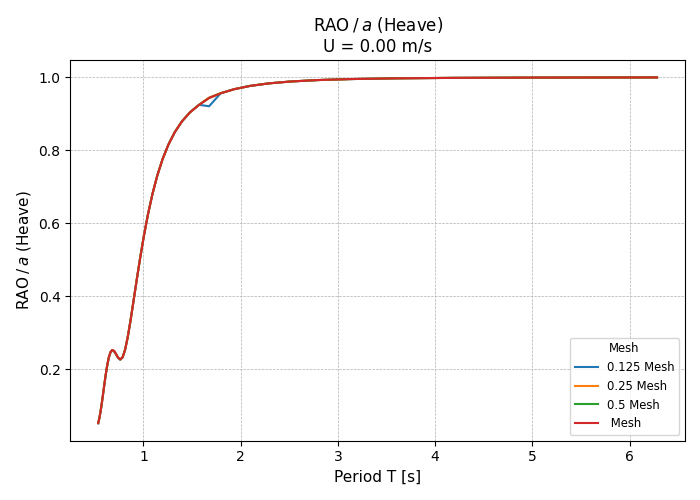

In [ ]:


import os
import numpy as np
import matplotlib.pyplot as plt


dof_names = ['Surge','Sway','Heave','Roll','Pitch','Yaw']

dof_name  = dof_names[dof_idx]

# output folder
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

# metrics configuration
metrics = {
    "added_mass": {
        "data": AM,
        "ylabel": r"Added‐mass / ($\rho\,\nabla$) (Heave)",
        "filename": "added_mass",
        "nd_func": lambda y: y/weight,
        "x": period
    },
    "radiation_damping": {
        "data": RD,
        "ylabel": r"Damping / ($\rho\,\nabla\,\omega$) (Heave)",
        "filename": "radiation_damping",
        "nd_func": lambda y: y/(weight*omega),
        "x": period
    },
    "forces": {
        "data": FX,
        "ylabel": r"Force / ($\rho\,g\,a\,L^{2}$) (Heave)",
        "filename": "excitation_force",
        "nd_func": lambda w,y: y/(rho*g*wave_amp*L**2),
    },
    "rao": {
        "data": RAO,
        "ylabel": r"RAO / $a$ (Heave)",
        "filename": "rao",
        "nd_func": lambda w,y: y/wave_amp,
    },
}

for U in speeds:
    for key, info in metrics.items():
        fig, ax = plt.subplots(figsize=(7,5))
        for mesh in meshes:
            # build legend label: "0.125 Mesh", "0.25 Mesh", …
            raw = mesh.split("Flat")[0]            # e.g. "0_125"
            label = raw.replace("_",".") + " Mesh"                # "0.125 Mesh"
            D = info["data"][mesh][U]
            if key in ("added_mass","radiation_damping"):
                x = info["x"]
                y = info["nd_func"](D)
            else:

                # forces & rao are dict w→val
                w = np.array(sorted(D))
                y_raw = np.array([D[wv] for wv in w])
                x = 2*np.pi/w
                idx = np.argsort(x)
                y = info["nd_func"](w, y_raw)[idx]
                x = x[idx]
            ax.plot(x, y, label=label, lw=1.5)



        ax.set_title(f"{info['ylabel']}\nU = {U:.2f} m/s", fontsize=12)
        ax.set_xlabel("Period T [s]", fontsize=11)
        ax.set_ylabel(info["ylabel"], fontsize=11)
        ax.grid(True, which="both", ls="--", lw=0.5)
        ax.legend(title="Mesh", fontsize="small", title_fontsize="small", loc="best")
        fig.tight_layout()
        # save
        fname = os.path.join(outdir, f"{info['filename']}_U{U:.2f}_{dof_name}.png")
        fig.savefig(fname, dpi=200)
        plt.show()

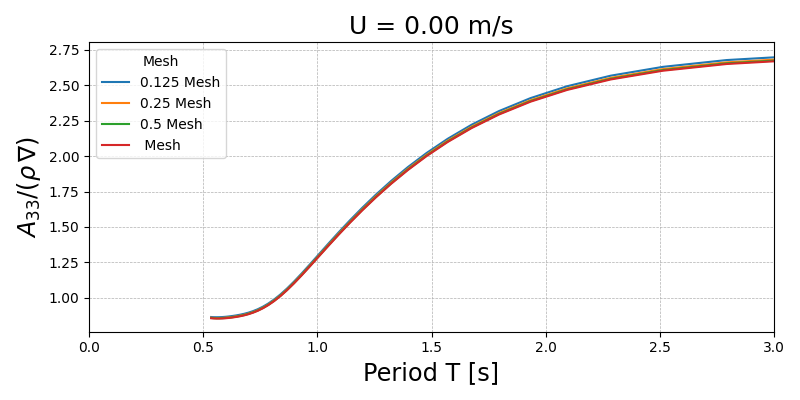

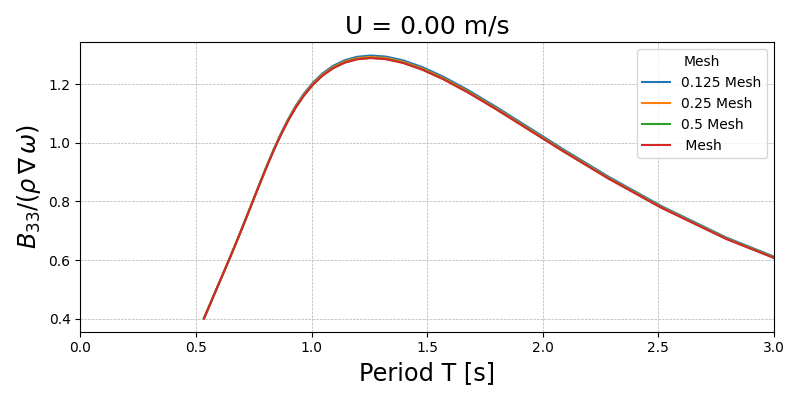

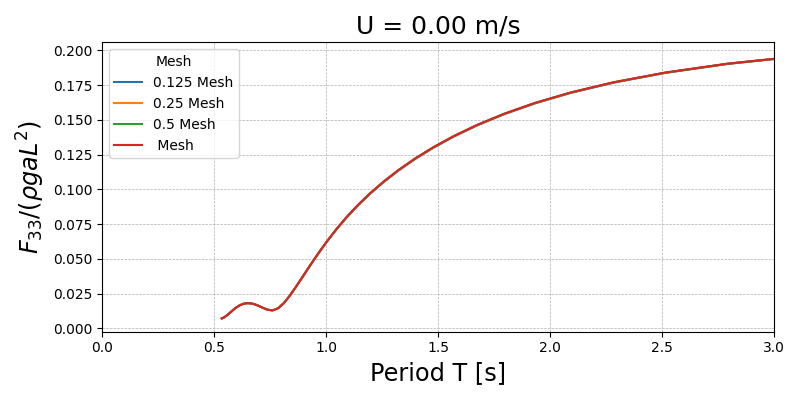

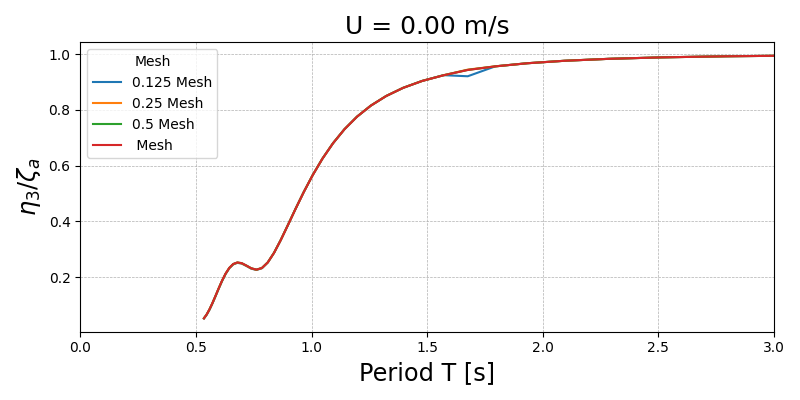

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# map dof_idx → name
dof_names = ['Surge','Sway','Heave','Roll','Pitch','Yaw']
dof_name  = dof_names[dof_idx]

# output folder
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

# metrics configuration
metrics = {
    "added_mass": {
        "data": AM,
        "filename": "A_33",
        "ylabel": r"$A_{33}/(\rho\,\nabla)$",    # normalize by ρ·∇
        "norm":   lambda y, w=None: y/weight,
        "x":      period
    },
    "radiation_damping": {
        "data": RD,
        "filename": "B_33",
        "ylabel": r"$B_{33}/(\rho\,\nabla\,\omega)$",
        "norm":   lambda y, w=None: y/(weight*omega),
        "x":      period
    },
    "forces": {
        "data": FX,
        "filename": "F_33",
        "ylabel": r"$F_{33}/(\rho g a L^2)$",
        "norm":   lambda y, w: y/(rho*g*wave_amp*L**2),
    },
    "rao": {
        "data": RAO,
        "filename": "eta3_zetaa",
        "ylabel": r"$\eta_3/\zeta_a$",
        "norm":   lambda y, w: y/wave_amp,
    },
}

for U in speeds:
    for key, info in metrics.items():
        fig, ax = plt.subplots(figsize=(8,4))
        for mesh in meshes:
            label = mesh.split("Flat")[0].replace("_",".") + " Mesh"
            D = info["data"][mesh][U]
            if key in ("added_mass","radiation_damping"):
                x = info["x"]
                y = info["norm"](D)
            else:
                w = np.array(sorted(D))
                y0 = np.array([D[w0] for w0 in w])
                T = 2*np.pi/w
                idx = np.argsort(T)
                x = T[idx]
                y = info["norm"](y0[idx], w[idx])
            # only keep T ≤ 3 s
            mask = x <= 3.3
            ax.plot(x[mask], y[mask], lw=1.5, label=label)

        ax.set_title(f"U = {U:.2f} m/s", fontsize=18)
        ax.set_xlabel("Period T [s]", fontsize="xx-large")
        ax.set_ylabel(info["ylabel"], fontsize="xx-large")
        ax.set_xlim(0, 3)
        ax.grid(True, which="both", ls="--", lw=0.5)
        ax.legend(title="Mesh", fontsize="medium", loc="best")
        fig.tight_layout()

        fname = os.path.join(outdir, f"{info['filename']}_U{U:.2f}_{dof_name}.png")
        fig.savefig(fname, dpi=400)
        plt.show()

In [ ]:


import numpy as np

ref_mesh = meshes[-1]   # finest mes
U0       = speeds[0]
pct_diff = {}

for key, info in metrics.items():
    # Build reference curv

    if key in ("added_mass", "radiation_damping"):
        x_ref = info["x"]
        y_ref = info["norm"](info["data"][ref_mesh][U0])
    else:
        w_ref = np.array(sorted(info["data"][ref_mesh][U0]))
        y0_ref = np.array([info["data"][ref_mesh][U0][w] for w in w_ref])
        T_ref = 2 * np.pi / w_ref
        idx   = np.argsort(T_ref)
        x_ref = T_ref[idx]
        y_ref = info["norm"](y0_ref[idx], w_ref[idx])

    # mask to T ≤ 3 s
    mask = x_ref <= 3.0
    x_mask = x_ref[mask]
    y_ref  = y_ref[mask]

    diffs = {}
    for mesh in meshes[:-1]:

        if key in ("added_mass", "radiation_damping"):
            y = info["norm"](info["data"][mesh][U0])
            y_m = y[mask]
        else:
            w_m    = np.array(sorted(info["data"][mesh][U0]))
            y0_m   = np.array([info["data"][mesh][U0][w] for w in w_m])
            T_m    = 2 * np.pi / w_m
            idx_m  = np.argsort(T_m)
            x_m    = T_m[idx_m]
            y_mall = info["norm"](y0_m[idx_m], w_m[idx_m])

            y_m = np.interp(x_mask, x_m, y_mall)

        err = np.abs((y_m - y_ref) / y_ref) * 100
        diffs[mesh] = np.mean(err)

    pct_diff[key] = diffs


for key, d in pct_diff.items():
    print(f"\nMetric: {key}")
    for mesh, val in d.items():
        label = mesh.split("Flat")[0].replace("_", ".")
        print(f"  {label} Mesh: {val:.2f}%")


Metric: added_mass
  0.125 Mesh: 1.14%
  0.25 Mesh: 0.45%
  0.5 Mesh: 0.21%

Metric: radiation_damping
  0.125 Mesh: 0.42%
  0.25 Mesh: 0.20%
  0.5 Mesh: 0.06%

Metric: forces
  0.125 Mesh: 0.37%
  0.25 Mesh: 0.23%
  0.5 Mesh: 0.14%

Metric: rao
  0.125 Mesh: 0.49%
  0.25 Mesh: 0.18%
  0.5 Mesh: 0.06%
